In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from nn import load_track_data, train_model, look_back, mod, summ, rnn
from keras.models import load_model
from weather_gen import generate_weather, h, w
from pandasql import sqldf
from pandas import read_csv
from time import time

os.chdir("C:/Users/adame/OneDrive/Bureau/IRP doc")

In [2]:
def dist(lon1,lon2,lat1,lat2,alt1,alt2):
    # Function to calculate the distance in km based on coordinates and altitudes
    d_flat = 6371 * np.arccos((np.sin(lat1) * np.sin(lat2)) + np.cos(lat1) * np.cos(lat2) * np.cos(lon2 - lon1)) # km
    d_h = alt1-alt2
    return(np.sqrt(d_flat * d_flat + d_h * d_h)) # Pythagoras for the final distance

def indexes(trajec_list):
    # Similarity index gathering similar trajectories
    # The differentiation is made on whether the latitude is within certain ranges
    
    index_list = []

    for traj in trajec_list:
        if traj[40][2] > 36.8:
            index_list.append(0)
        elif traj[40][2] > 34.5:
            index_list.append(1)
        else:
            index_list.append(2)

    return index_list

def is_above_threshold(d_coord, d_speed, th_coord = 0.5, th_speed = 0.05):
    return(d_coord > th_coord or d_speed > th_speed)

In [5]:
tracks = read_csv("C:/Users/adame/Documents/DeepTPmaster/src/DATA/flight_tracks.csv") # Real flight tracks (HOU to BOS)

In [6]:
# Get all distinct flight IDs
IDs = list(sqldf("SELECT DISTINCT FID FROM tracks WHERE FID IS NOT NULL")['FID'])
n_ids = len(IDs)

In [7]:
# List distinct trajectories
trajec_list = []
for ID in IDs:
    trajec_list.append(np.array(sqldf("SELECT FID AS ID, Lon, Lat, Alt, Speed FROM tracks WHERE FID = " + str(ID) )))

trajec_list = np.array(trajec_list)

# Number of columns without the ID
n_feat = trajec_list[0].shape[1]-1

In [8]:
# Generate training data from trajectory list
# trajectories are cut into segments of length "look_back", normalized (mu, sigma are mean and stddev) and shuffled
X_train, y_train, X_val, y_val, X_test, y_test, mu, sigma = load_track_data(trajec_list)

index_list = indexes(trajec_list)

In [9]:
h,w

(25, 25)

In [10]:
wcc, wind_v, wind_h = [], [], []

# Generate as many different datasets as there are different indexes
for _ in range(3):
    generate_weather(h,w)
    wcc.append(np.load("data_own/wcc.npy"))
    wind_v.append(np.load("data_own/wind_vert.npy"))
    wind_h.append(np.load("data_own/wind_horiz.npy"))
    os.remove("data_own/wcc.npy")
    os.remove("data_own/wind_vert.npy")
    os.remove("data_own/wind_horiz.npy")

# Create weather datasets
wcc_train, wcc_val, wcc_test = [],[],[]
wind_v_train, wind_v_val, wind_v_test = [],[],[]
wind_h_train, wind_h_val, wind_h_test = [],[],[]

for u in X_train:
    idd = (u[0]*sigma+mu)[0]
    for p in range(len(IDs)):
        if IDs[p]==idd:
            wcc_train.append(wcc[index_list[p]])
            wind_v_train.append(wind_v[index_list[p]])
            wind_h_train.append(wind_h[index_list[p]])

for u in X_val:
    idd = (u[0]*sigma+mu)[0]
    for p in range(len(IDs)):
        if IDs[p]==idd:
            wcc_val.append(wcc[index_list[p]])
            wind_v_val.append(wind_v[index_list[p]])
            wind_h_val.append(wind_h[index_list[p]])

for u in X_test:
    idd = (u[0]*sigma+mu)[0]
    for p in range(len(IDs)):
        if IDs[p]==idd:
            wcc_test.append(wcc[index_list[p]])
            wind_v_test.append(wind_v[index_list[p]])
            wind_h_test.append(wind_h[index_list[p]])

wcc_train, wcc_val, wcc_test = np.array(wcc_train).reshape((-1,h,w,1)), np.array(wcc_val).reshape((-1,h,w,1)), np.array(wcc_test).reshape((-1,h,w,1))
wind_v_train, wind_v_val, wind_v_test = np.array(wind_v_train).reshape((-1,h,w,1)), np.array(wind_v_val).reshape((-1,h,w,1)), np.array(wind_v_test).reshape((-1,h,w,1))
wind_h_train, wind_h_val, wind_h_test = np.array(wind_h_train).reshape((-1,h,w,1)), np.array(wind_h_val).reshape((-1,h,w,1)), np.array(wind_h_test).reshape((-1,h,w,1)) 

In [11]:
# Remove IDs from features and constants
X_train = X_train[:,:,1:n_feat+1]
X_val = X_val[:,:,1:n_feat+1]
X_test = X_test[:,:,1:n_feat+1]

y_train = y_train[:,1:n_feat+1]
y_val = y_val[:,1:n_feat+1]
y_test = y_test[:,1:n_feat+1]

mu = mu[1:n_feat+1]
sigma = sigma[1:n_feat+1]

In [13]:
# Initialize the model
epochs = 100
batch_size = 500

model = rnn(n_feat = n_feat)
#model = load_model('models/model')

# Compile
summ(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 100)           42000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 75)            52800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                25200     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 84        
Total params: 123,654
Trainable params: 123,654
Non-trainable params: 0
________________________________________________

In [14]:
t=time()
hist = model.fit(
	x = X_train, y = y_train,
	validation_data=(X_val, y_val),
	epochs = epochs, batch_size = batch_size)

Epoch 1/100
19/19 [==============================] - 19s 275ms/step - loss: 2.3317 - val_loss: 0.6016
Epoch 2/100
19/19 [==============================] - 4s 205ms/step - loss: 0.4812 - val_loss: 0.3622
Epoch 3/100
19/19 [==============================] - 4s 207ms/step - loss: 0.3342 - val_loss: 0.3110
Epoch 4/100
19/19 [==============================] - 4s 209ms/step - loss: 0.2953 - val_loss: 0.2947
Epoch 5/100
19/19 [==============================] - 4s 209ms/step - loss: 0.2752 - val_loss: 0.2419
Epoch 6/100
19/19 [==============================] - 4s 211ms/step - loss: 0.2389 - val_loss: 0.2515
Epoch 7/100
19/19 [==============================] - 4s 209ms/step - loss: 0.2391 - val_loss: 0.2491
Epoch 8/100
19/19 [==============================] - 4s 213ms/step - loss: 0.2226 - val_loss: 0.2573
Epoch 9/100
19/19 [==============================] - 4s 208ms/step - loss: 0.2289 - val_loss: 0.2111
Epoch 10/100
19/19 [==============================] - 4s 230ms/step - loss: 0.2078 - val_l

19/19 [==============================] - 4s 200ms/step - loss: 0.1617 - val_loss: 0.2119
Epoch 82/100
19/19 [==============================] - 4s 207ms/step - loss: 0.1513 - val_loss: 0.2468
Epoch 83/100
19/19 [==============================] - 4s 200ms/step - loss: 0.1797 - val_loss: 0.2126
Epoch 84/100
19/19 [==============================] - 4s 217ms/step - loss: 0.1593 - val_loss: 0.2218
Epoch 85/100
19/19 [==============================] - 4s 205ms/step - loss: 0.1378 - val_loss: 0.2265
Epoch 86/100
19/19 [==============================] - 4s 210ms/step - loss: 0.1408 - val_loss: 0.2345
Epoch 87/100
19/19 [==============================] - 4s 208ms/step - loss: 0.1400 - val_loss: 0.2402
Epoch 88/100
19/19 [==============================] - 4s 202ms/step - loss: 0.1524 - val_loss: 0.2281
Epoch 89/100
19/19 [==============================] - 4s 216ms/step - loss: 0.1273 - val_loss: 0.2225
Epoch 90/100
19/19 [==============================] - 4s 195ms/step - loss: 0.1281 - val_loss: 

In [15]:
print("training time: ",time()-t)

training time:  402.9185757637024


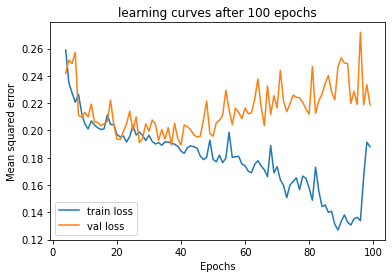

In [16]:
s = 4
plt.plot(range(s,epochs), hist.history['loss'][s:], label = "train loss")
plt.plot(range(s,epochs), hist.history['val_loss'][s:], label = "val loss")
plt.legend()
plt.title("learning curves after "+str(epochs)+" epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean squared error")
plt.show()

In [33]:
hist2 = model.fit(
	x = [wind_v_train, X_train], y = y_train,
	validation_data=([wind_v_val, X_val], y_val),
	epochs = epochs, batch_size = batch_size)

Epoch 1/20
182/182 [==============================] - 6s 35ms/step - loss: 0.2194 - val_loss: 0.1809
Epoch 2/20
182/182 [==============================] - 10s 53ms/step - loss: 0.2201 - val_loss: 0.1827
Epoch 3/20
182/182 [==============================] - 8s 42ms/step - loss: 0.2166 - val_loss: 0.2175
Epoch 4/20
182/182 [==============================] - 6s 35ms/step - loss: 0.2098 - val_loss: 0.1799
Epoch 5/20
182/182 [==============================] - 7s 39ms/step - loss: 0.2068 - val_loss: 0.1702
Epoch 6/20
182/182 [==============================] - 8s 42ms/step - loss: 0.2026 - val_loss: 0.1694
Epoch 7/20
182/182 [==============================] - 6s 34ms/step - loss: 0.2033 - val_loss: 0.1779
Epoch 8/20
182/182 [==============================] - 8s 43ms/step - loss: 0.2052 - val_loss: 0.1809
Epoch 9/20
182/182 [==============================] - 7s 36ms/step - loss: 0.2084 - val_loss: 0.1976
Epoch 10/20
182/182 [==============================] - 7s 40ms/step - loss: 0.2123 - val_l

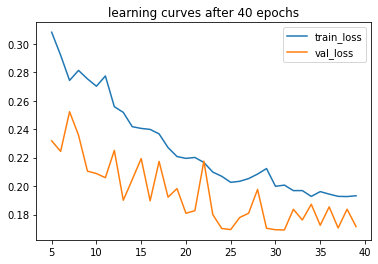

In [44]:
plt.plot(range(s,2*epochs), (list(hist.history['loss'])+list(hist2.history['loss']))[s:], label = "train loss")
plt.plot(range(s,2*epochs), (list(hist.history['val_loss'])+list(hist2.history['val_loss']))[s:], label = "val loss")
plt.legend()
plt.title("learning curves after "+str(2*epochs)+" epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean squared error")
plt.show()

In [39]:
hist3 = model.fit(
	x = [wind_v_train, X_train], y = y_train,
	validation_data=([wind_v_val, X_val], y_val),
	epochs = epochs, batch_size = batch_size)

Epoch 1/20
182/182 [==============================] - 6s 35ms/step - loss: 0.1949 - val_loss: 0.1847
Epoch 2/20
182/182 [==============================] - 6s 35ms/step - loss: 0.1885 - val_loss: 0.1755
Epoch 3/20
182/182 [==============================] - 7s 40ms/step - loss: 0.1904 - val_loss: 0.1715
Epoch 4/20
182/182 [==============================] - 6s 34ms/step - loss: 0.1850 - val_loss: 0.1854
Epoch 5/20
182/182 [==============================] - 6s 34ms/step - loss: 0.1885 - val_loss: 0.1706
Epoch 6/20
182/182 [==============================] - 7s 39ms/step - loss: 0.1904 - val_loss: 0.1996
Epoch 7/20
182/182 [==============================] - 6s 34ms/step - loss: 0.1857 - val_loss: 0.1901
Epoch 8/20
182/182 [==============================] - 7s 36ms/step - loss: 0.1961 - val_loss: 0.1903
Epoch 9/20
182/182 [==============================] - 8s 42ms/step - loss: 0.1915 - val_loss: 0.1897
Epoch 10/20
182/182 [==============================] - 7s 37ms/step - loss: 0.1877 - val_lo

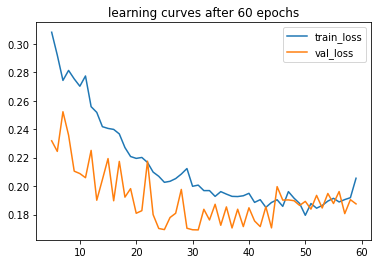

In [45]:
plt.plot(range(s,3*epochs), (list(hist.history['loss'])+list(hist2.history['loss'])+list(hist3.history['loss']))[s:], label = "train_loss")
plt.plot(range(s,3*epochs), (list(hist.history['val_loss'])+list(hist2.history['val_loss'])+list(hist3.history['val_loss']))[s:], label = "val_loss")
plt.legend()
plt.title("learning curves after "+str(3*epochs)+" epochs")
plt.show()

In [27]:
X_train.shape

(9069, 30, 4)

In [ ]:
model.save("models/model")
print("Saved after "+str(2*epochs)+" epochs")

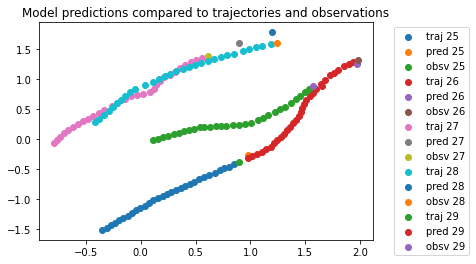

In [46]:
# Plot a couple trajectories, observation and prediction

u = model.predict([wind_v_test, X_test])
for p in range(25,30):
    plt.scatter(X_test[p][:,0],X_test[p][:,1], label = "traj "+str(p))
    plt.scatter(u[p][0],u[p][1], label = "pred " + str(p))
    plt.scatter(y_test[p][0], y_test[p][1], label = "obsv " + str(p))

plt.legend(bbox_to_anchor=(1.4, 1))
plt.title("Model predictions compared to trajectories and observations")
plt.show()

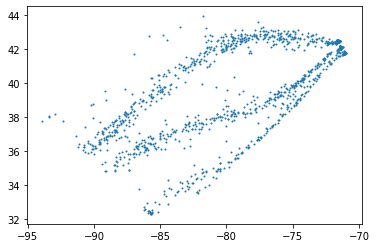

In [74]:
u.shape
plt.scatter(u[:,0]*sigma[0] + mu[0], u[:,1]*sigma[1] + mu[1],s=1)

In [72]:
mu

array([-8.44515921e+01,  3.71297540e+01,  3.49804793e+02,  1.30466034e-01])

In [92]:
# Create FL framework
## Partition data among aircrafts

n_acs = 4
acs = list(range(n_acs))

models = [mod(n_feat) for _ in range(n_acs)]
model_agg = mod(n_feat)

n_train_data_ac = int(X_train.shape[0]/n_acs)

fl_X_train_traj = [0 for _ in range(n_acs)]
fl_X_train_w = [0 for _ in range(n_acs)]
fl_y_train = [0 for _ in range(n_acs)]

for i in range(n_acs-1):
    fl_X_train_traj[i] = X_train[i*n_train_data_ac:(i+1)*n_train_data_ac]
    fl_X_train_w[i] = wind_v_train[i*n_train_data_ac:(i+1)*n_train_data_ac]
    fl_y_train[i] = y_train[i*n_train_data_ac:(i+1)*n_train_data_ac]
    summ(models[i])
    
fl_X_train_traj[n_acs-1] = X_train[(n_acs-1)*n_train_data_ac:]
fl_X_train_w[n_acs-1] = wind_v_train[(n_acs-1)*n_train_data_ac:]
fl_y_train[n_acs-1] = y_train[(n_acs-1)*n_train_data_ac:]
summ(models[n_acs-1])

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 23, 23, 16)   160         input_23[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D) (None, 11, 11, 16)   0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 30, 4)]      0                                            
___________________________________________________________________________________________

In [93]:
############# Training phase #############

# Training using FL

from keras.losses import MeanSquaredError
t=time()
n_cycles = 10

epochs = 10
batch_size = 256

weights_agg = []
hists = [[] for _ in range(n_acs)]

fl_penalty = 0
classic_penalty = np.size(X_train)

model_agg = mod(n_feat = n_feat)

losses = []
mse = MeanSquaredError()

for p in range(n_cycles):
    print("Cycle", p+1)
    weights = [0 for _ in range(n_acs)]
    for ac in range(n_acs):
        print("Aircraft",ac+1)
        hists[ac].append(models[ac].fit(x = [fl_X_train_w[ac], fl_X_train_traj[ac]], y = fl_y_train[ac],
            epochs = epochs, batch_size = batch_size, verbose=2))
        weights[ac] = models[ac].get_weights()
    
    if p==0:
        n_arrays = len(weights[0])
        for layer in range(n_arrays):
            weights_agg.append(np.zeros(np.shape(weights[0][layer])))

    weights_agg_tmp = []
    for layer in range(n_arrays):
        weights_agg_tmp.append(np.zeros(np.shape(weights[0][layer])))

    for layer in range(n_arrays):
        for ac in range(n_acs):
            weights_agg_tmp[layer] += weights[ac][layer]
        weights_agg_tmp[layer] /= n_acs
    
    for layer in range(n_arrays):
        weights_agg[layer] = (weights_agg[layer] + weights_agg_tmp[layer]) / 2
    
    model_agg.set_weights(weights_agg)
    agg_pred = model_agg.predict([wind_v_test, X_test])
    
    losses.append(mse(y_test, agg_pred).numpy())
    
    fl_penalty += sum([np.size(u) for u in weights_agg])
    
    print(mse(y_test, agg_pred).numpy())
    
print(time()-t)

Cycle 1
Aircraft 1
Epoch 1/10
9/9 - 8s - loss: 328.1417
Epoch 2/10
9/9 - 2s - loss: 126.4191
Epoch 3/10
9/9 - 2s - loss: 220.5399
Epoch 4/10
9/9 - 2s - loss: 19.0935
Epoch 5/10
9/9 - 2s - loss: 5.4181
Epoch 6/10
9/9 - 2s - loss: 3.3689
Epoch 7/10
9/9 - 2s - loss: 2.2198
Epoch 8/10
9/9 - 2s - loss: 1.6178
Epoch 9/10
9/9 - 2s - loss: 1.3246
Epoch 10/10
9/9 - 2s - loss: 1.0822
Aircraft 2
Epoch 1/10
9/9 - 6s - loss: 435.1617
Epoch 2/10
9/9 - 2s - loss: 65.7041
Epoch 3/10
9/9 - 2s - loss: 53.0260
Epoch 4/10
9/9 - 2s - loss: 8.5327
Epoch 5/10
9/9 - 2s - loss: 4.4428
Epoch 6/10
9/9 - 2s - loss: 2.9872
Epoch 7/10
9/9 - 2s - loss: 2.2781
Epoch 8/10
9/9 - 2s - loss: 2.0324
Epoch 9/10
9/9 - 2s - loss: 1.9626
Epoch 10/10
9/9 - 2s - loss: 1.9650
Aircraft 3
Epoch 1/10
9/9 - 7s - loss: 464.9522
Epoch 2/10
9/9 - 2s - loss: 176.9886
Epoch 3/10
9/9 - 2s - loss: 44.9535
Epoch 4/10
9/9 - 2s - loss: 9.8566
Epoch 5/10
9/9 - 2s - loss: 3.9871
Epoch 6/10
9/9 - 2s - loss: 1.9517
Epoch 7/10
9/9 - 2s - loss: 1.3

Epoch 4/10
9/9 - 1s - loss: 0.2772
Epoch 5/10
9/9 - 1s - loss: 0.2778
Epoch 6/10
9/9 - 1s - loss: 0.2753
Epoch 7/10
9/9 - 1s - loss: 0.2747
Epoch 8/10
9/9 - 1s - loss: 0.2756
Epoch 9/10
9/9 - 1s - loss: 0.2752
Epoch 10/10
9/9 - 1s - loss: 0.2717
Aircraft 4
Epoch 1/10
9/9 - 1s - loss: 0.3804
Epoch 2/10
9/9 - 1s - loss: 0.3712
Epoch 3/10
9/9 - 1s - loss: 0.3653
Epoch 4/10
9/9 - 1s - loss: 0.3656
Epoch 5/10
9/9 - 2s - loss: 0.3644
Epoch 6/10
9/9 - 1s - loss: 0.3753
Epoch 7/10
9/9 - 1s - loss: 0.3738
Epoch 8/10
9/9 - 1s - loss: 0.3560
Epoch 9/10
9/9 - 1s - loss: 0.3464
Epoch 10/10
9/9 - 1s - loss: 0.3383
2.1904192
Cycle 7
Aircraft 1
Epoch 1/10
9/9 - 1s - loss: 0.2171
Epoch 2/10
9/9 - 1s - loss: 0.2225
Epoch 3/10
9/9 - 1s - loss: 0.2166
Epoch 4/10
9/9 - 1s - loss: 0.2137
Epoch 5/10
9/9 - 1s - loss: 0.2183
Epoch 6/10
9/9 - 1s - loss: 0.2168
Epoch 7/10
9/9 - 1s - loss: 0.2122
Epoch 8/10
9/9 - 1s - loss: 0.2104
Epoch 9/10
9/9 - 1s - loss: 0.2045
Epoch 10/10
9/9 - 1s - loss: 0.2033
Aircraft 2
E

In [94]:
print("##### PARAMETERS #####\n")
print("FL cycles:", n_cycles)
print("No of aircrafts:",n_acs)
print("Epochs:",epochs)
print("Batch size:", batch_size)
print("Delay parameter:", look_back)
print("Observations per aircraft:",fl_X_train_traj[0].shape[0])

print("\nFL penalty:",fl_penalty,"\nclassic penalty:", classic_penalty)
print("Aggregated model errors over the cycles:\n", losses)
print("Ratio:",fl_penalty/classic_penalty)

##### PARAMETERS #####

FL cycles: 10
No of aircrafts: 4
Epochs: 10
Batch size: 256
Delay parameter: 30
Observations per aircraft: 2267

FL penalty: 861540 
classic penalty: 1088280
Aggregated model errors over the cycles:
 [2.2944446, 2.251549, 2.2296543, 2.2164423, 2.2016373, 2.1904192, 2.1806235, 2.1751394, 2.1709895, 2.1669648]
Ratio: 0.7916528834491123


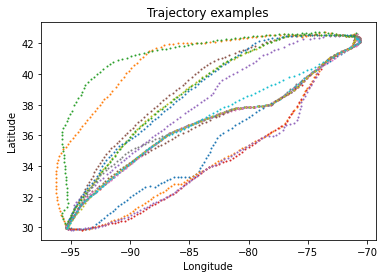

In [100]:
traj_sample = []

for p in range(20):
    traj_sample.append(trajec_list[p][:,1:])
    plt.scatter(trajec_list[p][:,1], trajec_list[p][:,2], s=1)

plt.title("Trajectory examples")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

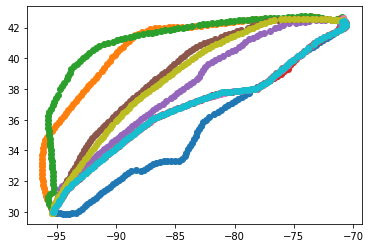

0
pred 
 [-8.28899275e+01  3.50290618e+01  3.94216761e+02  1.34999464e-01]
traj_i 
 [-8.79000000e+01  3.26500000e+01  3.50000000e+02  1.22889715e-01]
1
pred 
 [-8.33968144e+01  3.56246452e+01  3.92673378e+02  1.34026541e-01]
traj_i 
 [-9.44000000e+01  3.62500000e+01  3.50000000e+02  1.15939527e-01]
2
pred 
 [-8.32631797e+01  3.54096687e+01  3.90971414e+02  1.33885308e-01]
traj_i 
 [-9.54833333e+01  3.67000000e+01  3.70000000e+02  1.49163639e-01]
3
pred 
 [-8.27213490e+01  3.50391870e+01  3.93323344e+02  1.33654912e-01]
traj_i 
 [-8.92833333e+01  3.46166667e+01  3.70000000e+02  1.16870248e-01]
4
pred 
 [-8.28250540e+01  3.50828804e+01  3.93430874e+02  1.34076214e-01]
traj_i 
 [-8.95666667e+01  3.50000000e+01  3.50000000e+02  1.16503525e-01]
5
pred 
 [-8.28692022e+01  3.54045557e+01  3.90806567e+02  1.32976491e-01]
traj_i 
 [-9.06833333e+01  3.58333333e+01  3.50000000e+02  1.26028724e-01]
6
pred 
 [-8.24948324e+01  3.50950893e+01  3.93609858e+02  1.33259959e-01]
traj_i 
 [-8.95000000e+01

In [62]:
############# Operational phase #############

penalties_n, penalties_s = [], []

traj_sample = []

for p in range(10):
    traj_sample.append(trajec_list[p][:,1:])

traj_sample = np.array(traj_sample)

for j in range(traj_sample.shape[0]):
    print(j)
    traj = traj_sample[j]
    n = traj.shape[0]
    pen_normal = 0
    pen_syst = 0
    coords_actual, coords_pred = [], []

    wind = (wind_v[index_list[j]]).reshape(1,h,w,1)
    
    for i in range(n):
        pen_normal += n_feat

        if i < look_back:
            pen_syst += n_feat
            coords_actual.append(traj[i])
            coords_pred.append(traj[i])

        else:
            last_n = coords_pred[i-look_back : i]
            pred = model.predict( [wind,np.array(last_n).reshape((1,look_back,4))] )
            pred = pred.reshape((4)) * sigma + mu
            d_coord = dist(pred[0], traj[i][0], pred[1], traj[i][1], pred[2]/1000, traj[i][2]/1000)
            d_speed = np.absolute(pred[3] - traj[i][3])
            
            if i==30:
                print("pred \n", pred)
                print("traj_i \n", traj[i])

            if is_above_threshold(d_coord, d_speed, th_coord = 500, th_speed = 50):
                pen_syst += n_feat
                coords_actual.append(traj[i])
                coords_pred.append(traj[i])

            else:
                coords_actual.append(traj[i])
                coords_pred.append(pred)

    penalties_n.append(pen_normal)
    penalties_s.append(pen_syst)

print(penalties_n)
print(penalties_s)


In [69]:
dist(-82.86, -89.21, 35.0621, 34.65, 0.393119, 0.350)

1007.9166066850124

In [27]:
losses

[<tf.Tensor: shape=(), dtype=float32, numpy=1.7545485>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.7955431>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0374403>]